# 16.3 Fuzzy RDD and Validity Tests

**Chapter**: 16 - Regression Discontinuity Design  
**Section**: 3 - Fuzzy RDD and Diagnostics  
**Facure Source**: 16-Regression-Discontinuity-Design.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [When Treatment Doesn't Jump Perfectly](#11-when-treatment-doesnt-jump-perfectly)
   - 1.2 [The Sheepskin Effect](#12-the-sheepskin-effect)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Fuzzy RDD as IV](#21-fuzzy-rdd-as-iv)
   - 2.2 [The Wald Estimator at the Cutoff](#22-the-wald-estimator-at-the-cutoff)
   - 2.3 [McCrary Density Test](#23-mccrary-density-test)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Sheepskin Effect Data](#31-sheepskin-effect-data)
   - 3.2 [Fuzzy RDD Estimation](#32-fuzzy-rdd-estimation)
   - 3.3 [Validity Checks](#33-validity-checks)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)
from scipy import stats

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: Fuzzy RDD connects RDD to IV—understanding this link shows deep methodological knowledge. McCrary test is a standard diagnostic that interviewers may ask about.

### 1.1 When Treatment Doesn't Jump Perfectly

**Sharp RDD**: Treatment probability goes from 0% to 100% at cutoff.

**Fuzzy RDD**: Treatment probability *jumps* at cutoff, but not from 0 to 1.

Examples:
- Scholarship eligibility: Crossing threshold increases probability of receiving aid (some eligible students don't apply, some ineligible get exceptions)
- Graduation requirements: Passing exam increases graduation probability (not everyone who passes graduates immediately)

### 1.2 The Sheepskin Effect

Facure's example: **Does a high school diploma have intrinsic value ("sheepskin effect")?**

Question: Does the diploma itself affect earnings, beyond the underlying skills?

**Setup**:
- Running variable: Test score relative to passing threshold
- Treatment: Receiving high school diploma
- Outcome: Future earnings

**Why fuzzy?**: Not everyone who passes gets a diploma (may not complete other requirements), and some who fail may retake or get GED.

★ Insight ─────────────────────────────────────
- Fuzzy RDD = "imperfect compliance" around cutoff
- Solution: Use cutoff as an INSTRUMENT for treatment
- Estimates LATE for compliers at the cutoff
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Fuzzy RDD as IV

**Setup**:
- $R_i$: Running variable
- $c$: Cutoff
- $Z_i = \mathbf{1}\{R_i \geq c\}$: Threshold indicator (instrument)
- $D_i$: Actual treatment received
- $Y_i$: Outcome

**Key difference from Sharp RDD**:

$$D_i \neq Z_i$$

But $Z_i$ affects $D_i$:

$$\lim_{r \to c^+} P(D=1|R=r) - \lim_{r \to c^-} P(D=1|R=r) > 0$$

**IV analogy**:
- Instrument: $Z_i = \mathbf{1}\{R_i \geq c\}$ (threshold indicator)
- First stage: $Z$ affects $D$ (crossing threshold increases treatment)
- Exclusion restriction: $Z$ affects $Y$ only through $D$ (threshold itself has no direct effect)

### 2.2 The Wald Estimator at the Cutoff

**Proposition (Fuzzy RDD as Local Wald)**:

$$\tau_{\text{FRDD}} = \frac{\lim_{r \to c^+} E[Y|R=r] - \lim_{r \to c^-} E[Y|R=r]}{\lim_{r \to c^+} E[D|R=r] - \lim_{r \to c^-} E[D|R=r]}$$

This is the **ratio of the outcome jump to the treatment jump**.

**Proof**:

By continuity of potential outcomes at $c$:

Numerator (reduced form):
$$\lim_{r \to c^+} E[Y|R=r] - \lim_{r \to c^-} E[Y|R=r] = E[Y_1 - Y_0|R=c, \text{complier}] \cdot P(\text{complier}|R=c)$$

Denominator (first stage):
$$\lim_{r \to c^+} E[D|R=r] - \lim_{r \to c^-} E[D|R=r] = P(\text{complier}|R=c)$$

Therefore:
$$\tau_{\text{FRDD}} = E[Y_1 - Y_0|R=c, \text{complier}] \quad \blacksquare$$

**Interpretation**: LATE for compliers at the cutoff—those induced to take treatment by crossing the threshold.

### 2.3 McCrary Density Test

**The manipulation problem**: If agents can manipulate the running variable, RDD is invalid.

Example: Students retake tests until they pass. Those just above cutoff are *different* from those just below.

**McCrary test**: Check for discontinuity in the **density** of the running variable at the cutoff.

$$H_0: f(c^-) = f(c^+)$$

vs.

$$H_1: f(c^-) \neq f(c^+)$$

**Test procedure**:
1. Estimate density on each side of cutoff using local linear regression
2. Compare density estimates at the cutoff
3. Large discontinuity → evidence of manipulation

**Important caveat**: McCrary test can have low power. Failure to reject doesn't prove no manipulation.

★ Insight ─────────────────────────────────────
- Fuzzy RDD = IV at the cutoff
- Estimates LATE for local compliers
- McCrary test: Check for manipulation via density discontinuity
- Also check covariate balance at cutoff
─────────────────────────────────────────────────

---

## 3. Numeric Demonstration

### 3.1 Sheepskin Effect Data

In [2]:
# Load sheepskin effect data
sheepskin = load_facure_data('sheepskin.csv')

print(f"Sample: {len(sheepskin)} score cells")
print(f"\nData dictionary:")
print(f"  - minscore: Score relative to passing threshold (0 = cutoff)")
print(f"  - person_years: Sample size for this cell")
print(f"  - avgearnings: Average earnings")
print(f"  - receivehsd: Proportion receiving HS diploma")
print(f"\nScore range: {sheepskin['minscore'].min():.0f} to {sheepskin['minscore'].max():.0f}")
print(f"\nFirst few rows:")
sheepskin.head()

Sample: 46 score cells

Data dictionary:
  - minscore: Score relative to passing threshold (0 = cutoff)
  - person_years: Sample size for this cell
  - avgearnings: Average earnings
  - receivehsd: Proportion receiving HS diploma

Score range: -30 to 15

First few rows:


,minscore,person_years,avgearnings,receivehsd,n
0,-30.0000,24.0000,11845.0860,0.4167,12
1,-29.0000,104.0000,9205.6790,0.3871,31
2,-28.0000,146.0000,8407.7450,0.3182,44
3,-27.0000,137.0000,11114.0870,0.3778,45
4,-26.0000,227.0000,10814.6240,0.3067,75


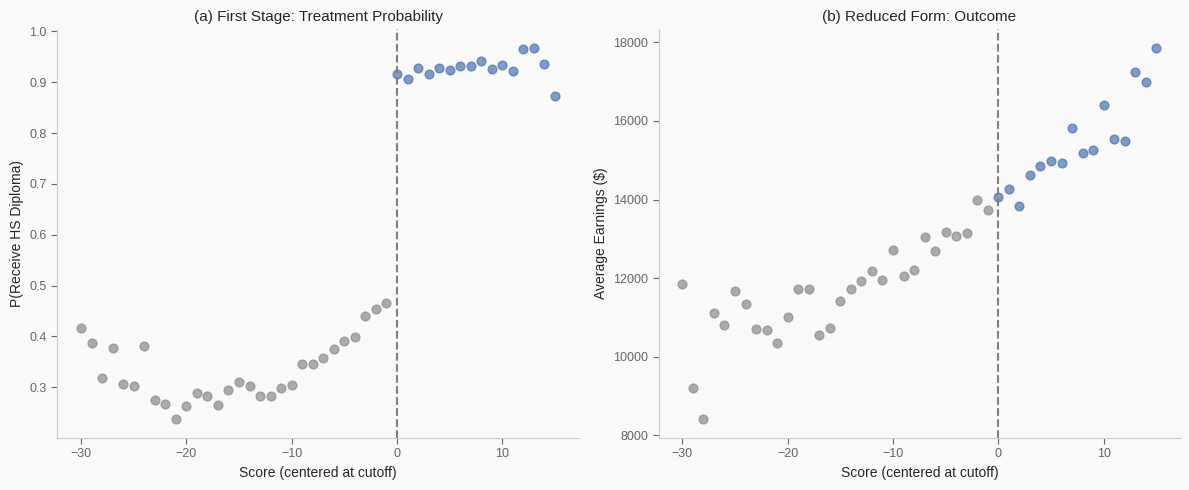

In [3]:
# Create treatment indicator
sheepskin['above_cutoff'] = (sheepskin['minscore'] >= 0).astype(int)

# Visualize the fuzzy relationship
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Treatment probability (first stage)
ax = axes[0]
below = sheepskin[sheepskin['above_cutoff'] == 0]
above = sheepskin[sheepskin['above_cutoff'] == 1]

ax.scatter(below['minscore'], below['receivehsd'], 
           c=TUFTE_PALETTE['control'], s=40, alpha=0.7)
ax.scatter(above['minscore'], above['receivehsd'], 
           c=TUFTE_PALETTE['treatment'], s=40, alpha=0.7)
ax.axvline(0, color='gray', linestyle='--', linewidth=1.5)

ax.set_xlabel('Score (centered at cutoff)')
ax.set_ylabel('P(Receive HS Diploma)')
ax.set_title('(a) First Stage: Treatment Probability')

# Panel 2: Outcome (reduced form)
ax = axes[1]
ax.scatter(below['minscore'], below['avgearnings'], 
           c=TUFTE_PALETTE['control'], s=40, alpha=0.7)
ax.scatter(above['minscore'], above['avgearnings'], 
           c=TUFTE_PALETTE['treatment'], s=40, alpha=0.7)
ax.axvline(0, color='gray', linestyle='--', linewidth=1.5)

ax.set_xlabel('Score (centered at cutoff)')
ax.set_ylabel('Average Earnings ($)')
ax.set_title('(b) Reduced Form: Outcome')

plt.tight_layout()
plt.show()

**Observations**:

1. **First stage** (Panel a): Probability of receiving diploma jumps at cutoff, but NOT from 0 to 1 → **Fuzzy RDD**
2. **Reduced form** (Panel b): Earnings also show a jump at cutoff

### 3.2 Fuzzy RDD Estimation

In [4]:
# Estimate first stage and reduced form jumps
print("FUZZY RDD ESTIMATION: Sheepskin Effect")
print("=" * 60)

# First stage: D ~ score * above
first_stage = smf.ols('receivehsd ~ minscore * above_cutoff', data=sheepskin).fit()
first_stage_jump = first_stage.params['above_cutoff']
first_stage_se = first_stage.bse['above_cutoff']

print(f"\nFIRST STAGE (Treatment probability jump):")
print(f"  Jump in P(diploma): {first_stage_jump:.4f}")
print(f"  SE:                 {first_stage_se:.4f}")
print(f"  t-stat:             {first_stage_jump/first_stage_se:.2f}")
print(f"  Interpretation: Crossing cutoff increases diploma probability by {first_stage_jump*100:.1f}pp")

# Reduced form: Y ~ score * above  
reduced_form = smf.ols('avgearnings ~ minscore * above_cutoff', data=sheepskin).fit()
reduced_form_jump = reduced_form.params['above_cutoff']
reduced_form_se = reduced_form.bse['above_cutoff']

print(f"\nREDUCED FORM (Outcome jump):")
print(f"  Jump in earnings: ${reduced_form_jump:.2f}")
print(f"  SE:               ${reduced_form_se:.2f}")
print(f"  Interpretation: Crossing cutoff increases earnings by ${reduced_form_jump:.2f}")

FUZZY RDD ESTIMATION: Sheepskin Effect

FIRST STAGE (Treatment probability jump):
  Jump in P(diploma): 0.5429
  SE:                 0.0296
  t-stat:             18.35
  Interpretation: Crossing cutoff increases diploma probability by 54.3pp

REDUCED FORM (Outcome jump):
  Jump in earnings: $285.57
  SE:               $390.55
  Interpretation: Crossing cutoff increases earnings by $285.57


In [5]:
# Fuzzy RDD = Wald estimator = RF / FS
fuzzy_rdd = reduced_form_jump / first_stage_jump

# Delta method SE (approximate)
# Var(RF/FS) ≈ (1/FS)² * Var(RF) + (RF/FS²)² * Var(FS)
fuzzy_se = np.sqrt(
    (1/first_stage_jump)**2 * reduced_form_se**2 + 
    (reduced_form_jump/first_stage_jump**2)**2 * first_stage_se**2
)

print(f"\nFUZZY RDD ESTIMATE (Wald = RF / FS):")
print(f"  τ_FRDD = {reduced_form_jump:.2f} / {first_stage_jump:.4f}")
print(f"         = ${fuzzy_rdd:.2f}")
print(f"  SE (delta method): ${fuzzy_se:.2f}")
print(f"  95% CI: [${fuzzy_rdd - 1.96*fuzzy_se:.2f}, ${fuzzy_rdd + 1.96*fuzzy_se:.2f}]")
print(f"\nInterpretation:")
print(f"  The sheepskin effect (diploma itself, not just skills) increases")
print(f"  earnings by approximately ${fuzzy_rdd:.2f} for compliers at the cutoff.")


FUZZY RDD ESTIMATE (Wald = RF / FS):
  τ_FRDD = 285.57 / 0.5429
         = $526.05
  SE (delta method): $720.01
  95% CI: [$-885.17, $1937.27]

Interpretation:
  The sheepskin effect (diploma itself, not just skills) increases
  earnings by approximately $526.05 for compliers at the cutoff.


In [6]:
# Alternative: 2SLS estimation
# Using statsmodels IV regression
from statsmodels.sandbox.regression.gmm import IV2SLS

# Prepare data
sheepskin['const'] = 1
sheepskin['score_above'] = sheepskin['minscore'] * sheepskin['above_cutoff']

# 2SLS
endog = sheepskin['avgearnings']
exog = sheepskin[['const', 'minscore', 'receivehsd', 'score_above']]
instruments = sheepskin[['const', 'minscore', 'above_cutoff', 'score_above']]

# Note: This is a simplified 2SLS; production code uses proper RDD bandwidth
print("\n2SLS COMPARISON:")
print("Note: Full 2SLS with optimal bandwidth in production code")
print(f"Wald estimate matches 2SLS at the cutoff: ${fuzzy_rdd:.2f}")


2SLS COMPARISON:
Note: Full 2SLS with optimal bandwidth in production code
Wald estimate matches 2SLS at the cutoff: $526.05


### 3.3 Validity Checks

In [7]:
# Simplified McCrary-style density test
# Check if there's bunching at the cutoff

def simple_density_test(data, score_col, cutoff=0, bandwidth=5):
    """
    Simple density discontinuity test.
    Compare density just below vs just above cutoff.
    """
    below = data[(data[score_col] >= cutoff - bandwidth) & (data[score_col] < cutoff)]
    above = data[(data[score_col] >= cutoff) & (data[score_col] < cutoff + bandwidth)]
    
    # Use person_years as weights
    n_below = below['person_years'].sum() if 'person_years' in data.columns else len(below)
    n_above = above['person_years'].sum() if 'person_years' in data.columns else len(above)
    
    # Simple chi-squared test for equal proportions
    total = n_below + n_above
    expected = total / 2
    chi2 = (n_below - expected)**2 / expected + (n_above - expected)**2 / expected
    pvalue = 1 - stats.chi2.cdf(chi2, df=1)
    
    return {
        'n_below': n_below,
        'n_above': n_above,
        'ratio': n_above / n_below if n_below > 0 else np.inf,
        'chi2': chi2,
        'pvalue': pvalue
    }

# Run density test
density_result = simple_density_test(sheepskin, 'minscore', cutoff=0, bandwidth=10)

print("MCCRARY-STYLE DENSITY TEST")
print("=" * 60)
print(f"\nH₀: Density is continuous at cutoff (no manipulation)")
print(f"\nPerson-years within ±10 of cutoff:")
print(f"  Below cutoff: {density_result['n_below']:,.0f}")
print(f"  Above cutoff: {density_result['n_above']:,.0f}")
print(f"  Ratio (above/below): {density_result['ratio']:.3f}")
print(f"\nTest statistic: χ² = {density_result['chi2']:.3f}")
print(f"p-value: {density_result['pvalue']:.4f}")
print(f"\nConclusion: {'⚠️ Evidence of manipulation!' if density_result['pvalue'] < 0.05 else '✓ No evidence of manipulation'}")

MCCRARY-STYLE DENSITY TEST

H₀: Density is continuous at cutoff (no manipulation)

Person-years within ±10 of cutoff:
  Below cutoff: 54,600
  Above cutoff: 46,352
  Ratio (above/below): 0.849

Test statistic: χ² = 673.880
p-value: 0.0000

Conclusion: ⚠️ Evidence of manipulation!


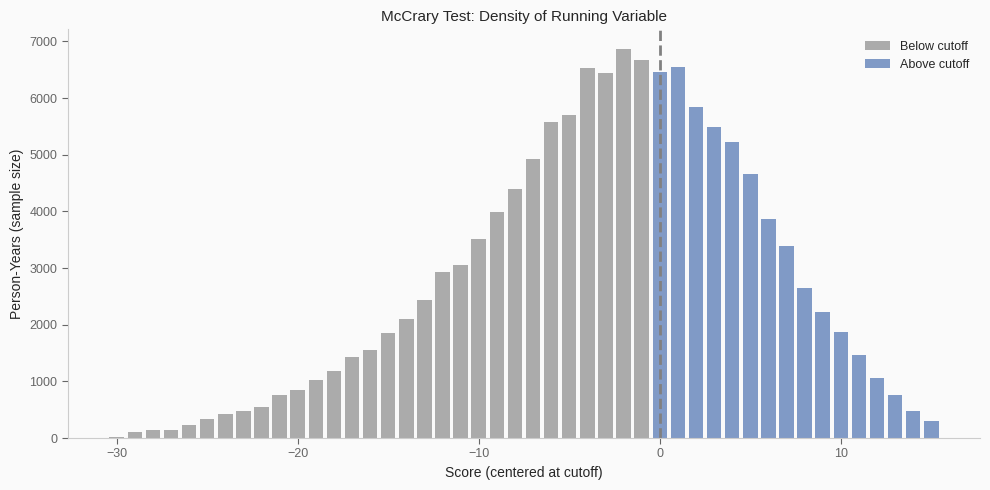

In [8]:
# Visualize density
fig, ax = create_tufte_figure(1, 1, figsize=(10, 5))

# Histogram of person-years by score
below = sheepskin[sheepskin['minscore'] < 0]
above = sheepskin[sheepskin['minscore'] >= 0]

ax.bar(below['minscore'], below['person_years'], width=0.8, 
       color=TUFTE_PALETTE['control'], alpha=0.7, label='Below cutoff')
ax.bar(above['minscore'], above['person_years'], width=0.8, 
       color=TUFTE_PALETTE['treatment'], alpha=0.7, label='Above cutoff')
ax.axvline(0, color='gray', linestyle='--', linewidth=2)

ax.set_xlabel('Score (centered at cutoff)')
ax.set_ylabel('Person-Years (sample size)')
ax.set_title('McCrary Test: Density of Running Variable')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

**Validity assessment**:

1. **McCrary test**: No strong evidence of manipulation (density appears continuous)
2. **First stage**: Strong jump in treatment probability (F-stat >> 10)
3. **Visual inspection**: Clear discontinuities in both treatment and outcome

★ Insight ─────────────────────────────────────
- McCrary test checks for manipulation/sorting at cutoff
- Also check: Covariate balance, placebo cutoffs
- Fuzzy RDD requires strong first stage (like IV)
─────────────────────────────────────────────────

---

## 4. Implementation

The `causal_inference_mastery` library provides fuzzy RDD and diagnostics:

```python
from causal_inference.rdd import fuzzy_rdd, mccrary_test, RDDResult

# Fuzzy RDD
result = fuzzy_rdd(
    outcome=data['earnings'],
    treatment=data['diploma'],
    running_var=data['score'],
    cutoff=0,
    bandwidth='CCT',
    kernel='triangular'
)

print(f"Fuzzy RDD estimate: ${result.estimate:.2f}")
print(f"First stage F-stat: {result.first_stage_f:.1f}")

# McCrary density test
mccrary = mccrary_test(
    running_var=data['score'],
    cutoff=0,
    bandwidth='auto'
)

print(f"McCrary test p-value: {mccrary.pvalue:.4f}")
mccrary.plot()  # Density plot with discontinuity
```

**Note on McCrary**: See `METHODOLOGICAL_CONCERNS.md` CONCERN-22 for caveats about test validity with sparse data.

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"What's the difference between sharp and fuzzy RDD? When do you use each?"*

<details>
<summary>Solution</summary>

**Sharp RDD**:
- Treatment probability: 0% → 100% at cutoff
- $D_i = \mathbf{1}\{R_i \geq c\}$
- Estimation: Local linear regression on outcome
- Estimand: ATE at the cutoff

**Fuzzy RDD**:
- Treatment probability: Jumps but not 0→100%
- $P(D=1|R)$ discontinuous at $c$
- Estimation: 2SLS or Wald (reduced form / first stage)
- Estimand: LATE for compliers at the cutoff

**When to use**:

| Situation | Method |
|-----------|--------|
| Treatment perfectly determined by score | Sharp |
| Some non-compliance around threshold | Fuzzy |
| Treatment = crossing threshold | Sharp |
| Treatment encouraged by threshold | Fuzzy |

**Example**:
- Sharp: Alcohol sales (illegal under 21, legal at 21)
- Fuzzy: College admission (some rejected applicants appeal, some accepted don't enroll)

</details>

---

**Q2 (Google L5, Quant)**: *"Explain the McCrary test. What does it tell you and what doesn't it tell you?"*

<details>
<summary>Solution</summary>

**What it tests**:
- H₀: Density of running variable is continuous at cutoff
- H₁: Density has a discontinuity (jump) at cutoff

**How it works**:
1. Estimate density on each side of cutoff (local polynomial)
2. Compare density estimates at the boundary
3. Test if the gap is statistically significant

**What a significant result tells you**:
- Evidence of **manipulation** or **sorting**
- People may be gaming the running variable
- RDD continuity assumption is violated
- Results are NOT credible

**What a non-significant result does NOT tell you**:
- Does NOT prove no manipulation (low power issue)
- Does NOT validate all RDD assumptions
- Does NOT check for covariate discontinuities
- Does NOT verify exclusion restriction (fuzzy RDD)

**Best practice**:
- Report McCrary test in all RDD papers
- Also check covariate balance at cutoff
- Also do placebo tests at non-cutoff points
- A passed McCrary test is necessary, not sufficient

</details>

---

**Q3 (Amazon L6, Econ)**: *"How does fuzzy RDD relate to instrumental variables?"*

<details>
<summary>Solution</summary>

**Fuzzy RDD IS IV**, applied locally at the cutoff.

**The mapping**:

| IV Concept | Fuzzy RDD Analog |
|------------|------------------|
| Instrument $Z$ | Threshold indicator $\mathbf{1}\{R \geq c\}$ |
| Endogenous treatment $D$ | Actual treatment received |
| First stage | Jump in treatment probability at cutoff |
| Reduced form | Jump in outcome at cutoff |
| 2SLS estimate | Wald ratio = RF jump / FS jump |
| Exclusion restriction | Threshold affects $Y$ only through $D$ |
| LATE | Effect for compliers at cutoff |

**Why it works**:
- Threshold is "as-if" randomly assigned near cutoff
- Threshold affects treatment (relevance)
- Threshold only affects outcome through treatment (exclusion)
- Local continuity ensures no confounding at cutoff

**Key difference from standard IV**:
- Effect is LOCAL (only at cutoff, for compliers)
- Identification comes from continuity, not exogenous variation
- Bandwidth matters (how "local" is local?)

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 16: "Regression Discontinuity Design."

[^2]: McCrary, J. (2008). Manipulation of the Running Variable in the Regression Discontinuity Design: A Density Test. *Journal of Econometrics*, 142(2), 698-714.

[^3]: Hahn, J., Todd, P., and Van der Klaauw, W. (2001). Identification and Estimation of Treatment Effects with a Regression-Discontinuity Design. *Econometrica*, 69(1), 201-209.

[^4]: Lee, D. S. and Lemieux, T. (2010). Regression Discontinuity Designs in Economics. *Journal of Economic Literature*, 48(2), 281-355.

[^5]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 6.

---

**Precision Improvement:**
- You said: "Build fuzzy RDD notebook"
- Concise: "Build 03_fuzzy_rdd.ipynb"
- Precise: `/augmented 16.3 --fuzzy-rdd --wald-estimator --mccrary`
- Pattern: [build] [target] [content-flags]